

# **Temporal-Difference методы (методы временно́го различия)**

В этом ноутбуке вы реализуете собственные версии различных методов Temporal-Difference (TD).

Хотя ниже предоставлен стартовый код, вы можете удалить эти подсказки и написать решение с нуля.

---

### **Часть 0: Исследование среды `CliffWalkingEnv`**

Начнём с импорта необходимых библиотек.



In [1]:
import sys
import gym
import numpy as np
import pandas as pd
import random
import math
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline

import check_test
from plot_utils import plot_values

In [2]:
import warnings
warnings.filterwarnings('ignore')


Используйте кодовую ячейку ниже, чтобы создать экземпляр среды [`CliffWalking`](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py).

CliffWalking-v0 — это дискретная среда из набора Gym, моделирующая задачу обучения с подкреплением в виде сетки (gridworld).

Агент стартует в левом нижнем углу и должен добраться до правого нижнего угла, избегая "обрыва" (cliff) — опасных клеток, ведущих к большой штрафной награде и перезапуску эпизода.

    Цель — минимизировать общее число шагов и штрафов, выработав оптимальную стратегию передвижения.

In [5]:
env = gym.make('CliffWalking-v0', render_mode="ansi")

In [7]:
env.reset()
print(env.render())

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T




Агент перемещается по сетке размером \$4 \times 12\$, где состояния пронумерованы следующим образом:

```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```

В начале каждого эпизода агент находится в состоянии `36`.
Состояние `47` — единственное терминальное.
Обрыв (cliff) соответствует состояниям от `37` до `46`.

У агента есть 4 возможных действия:

```
UP    = 0
RIGHT = 1
DOWN  = 2
LEFT  = 3
```

Таким образом:

* \$\mathcal{S}^+ = {0, 1, \ldots, 47}\$ — множество всех состояний
* \$\mathcal{A} = {0, 1, 2, 3}\$ — множество всех действий

Каждый шаг даёт награду `-1`,
падение в обрыв — награду `-100` и сброс в стартовое состояние.
Эпизод завершается, когда агент достигает цели.


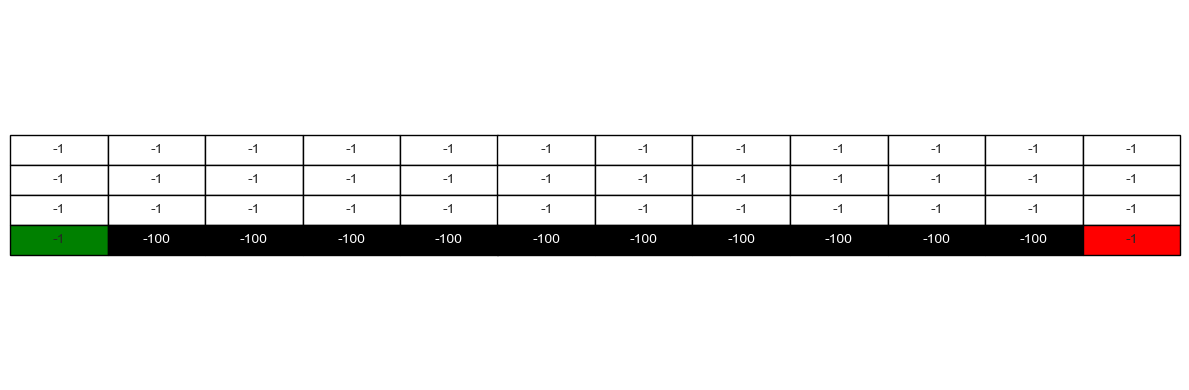

In [36]:
nrow, ncol = env.shape
n_states = env.observation_space.n
n_actions = env.action_space.n
start_state = ncol * (nrow - 1)
goal_state = n_states - 1


rewards = np.empty((nrow, ncol), dtype=int)
for s in range(n_states):
    i, j = divmod(s, ncol)
    found = False

    for t in range(n_states):
        if found: break
        for a in range(n_actions):
            for prob, next_s, r, done in env.P[t][a]:
                if next_s == s and r != -100:
                    rewards[i, j] = r
                    found = True
                    break
            if found: break

    if not found:
        rewards[i, j] = -100

# 4) Собираем цветовую карту
colors = [['white'] * ncol for _ in range(nrow)]
# чёрным — обрыв
for s in range(n_states):
    i, j = divmod(s, ncol)
    if rewards[i, j] == -100 and s not in (start_state, goal_state):
        colors[i][j] = 'black'

si, sj = divmod(start_state, ncol); colors[si][sj] = 'green'
gi, gj = divmod(goal_state,  ncol); colors[gi][gj] = 'red'


cell_text = [[str(rewards[i, j]) for j in range(ncol)]
             for i in range(nrow)]

# 6) Рисуем таблицу
fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('off')
tbl = ax.table(
    cellText   = cell_text,
    cellColours= colors,
    cellLoc    = 'center',
    loc        = 'center'
)


for s in range(n_states):
    i, j = divmod(s, ncol)
    if colors[i][j] == 'black':
        tbl[i, j].get_text().set_color('white')

tbl.scale(1, 1.5)
plt.tight_layout()
plt.show()

In [ ]:
print(env.action_space)
print(env.observation_space)

В этом мини-проекте мы будем постепенно продвигаться к построению оптимальной стратегии (policy) для среды CliffWalking.  
Ниже представлена визуализация оптимальной функции ценности состояний (optimal state-value function).  
Пожалуйста, уделите время тому, чтобы разобраться, **почему именно эти значения** отражают оптимальную функцию ценности.

_**Примечание:** Вы можете смело игнорировать значения в «обрывных» состояниях, так как они **не являются настоящими состояниями**, из которых агент может принимать решения.  
Для этих обрывов функция ценности состояний строго не определена._


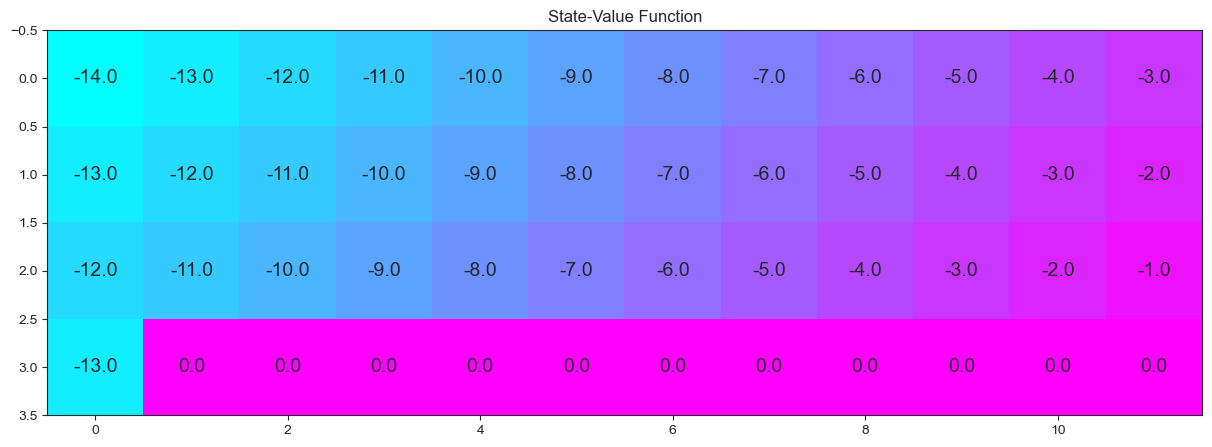

In [8]:
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0][0:13] = -np.arange(3, 15)[::-1]
V_opt[1][0:13] = -np.arange(3, 15)[::-1] + 1
V_opt[2][0:13] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

### Часть 1: Управление с помощью TD: алгоритм Sarsa

В этом разделе вам предстоит реализовать алгоритм управления на основе Temporal-Difference обучения — **Sarsa**.

---

Ваш алгоритм должен принимать следующие аргументы:

- `env`: объект среды OpenAI Gym.
- `num_episodes`: количество эпизодов, генерируемых в процессе взаимодействия агента со средой.
- `alpha`: параметр шага обучения (скорость обновления оценок).
- `gamma`: коэффициент дисконтирования. Значение должно находиться в пределах от `0` до `1` включительно (по умолчанию: `1`).

---

В качестве результата функция должна возвращать:

- `Q`: словарь (dictionary), где каждому состоянию `s` соответствует одномерный массив оценок действий:  
  `Q[s][a]` — это оценка действия `a` в состоянии `s`.

---

_Вы можете определить дополнительные функции, если это поможет структурировать ваш код._


In [9]:
def update_Q_sarsa(alpha, gamma, Q, state, action, reward, next_state=None, next_action=None):
    """Возвращает обновлённое значение Q для последнего опыта (эпизода взаимодействия агента со средой)."""
    current = Q[state][action]  # текущая оценка Q(s, a) из таблицы
    # значение Q(s', a') на следующем шаге
    Qsa_next = Q[next_state][next_action] if next_state is not None else 0    
    target = reward + (gamma * Qsa_next)               # TD-цель
    new_value = current + (alpha * (target - current)) # обновлённое значение Q(s, a)
    return new_value

def epsilon_greedy(Q, state, nA, eps):
    """Выбирает действие по стратегии epsilon-greedy для заданного состояния.

    Параметры
    =========
        Q (dictionary): функция action-value
        state (int): текущее состояние
        nA (int): количество действий в среде
        eps (float): параметр эпсилон
    """
    if random.random() > eps: # выбрать жадное действие с вероятностью 1 - epsilon
        return np.argmax(Q[state])
    else:                     # иначе выбрать случайное действие
        return random.choice(np.arange(env.action_space.n))


In [15]:
def sarsa(env, num_episodes, alpha, gamma=1.0, plot_every=100):
    nA = env.action_space.n                # количество действий
    Q = defaultdict(lambda: np.zeros(nA))  # инициализируем Q-функцию как словарь из массивов
    
    # для отслеживания производительности
    tmp_scores = deque(maxlen=plot_every)     # временное хранилище очков (окно длиной plot_every)
    avg_scores = deque(maxlen=num_episodes)   # средние очки за каждые plot_every эпизодов
    
    for i_episode in range(1, num_episodes+1):
        # отслеживаем прогресс
        if i_episode % 100 == 0:
            print("\rЭпизод {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        score = 0                            # обнуляем счёт
        state, _ = env.reset()                # начинаем новый эпизод
        
        eps = 1.0 / i_episode               # уменьшаем эпсилон со временем
        action = epsilon_greedy(Q, state, nA, eps)  # выбираем действие по epsilon-greedy
        
        while True:
            next_state, reward, terminated, truncated, info = env.step(action)  # выполняем действие A, получаем R, S'
            done = terminated or truncated
            score += reward                                     # добавляем награду к счёту
            
            if not done:
                next_action = epsilon_greedy(Q, next_state, nA, eps)  # выбираем следующее действие
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q,
                                                  state, action, reward, next_state, next_action)
                state = next_state      # S <- S'
                action = next_action    # A <- A'
            if done:
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q,
                                                  state, action, reward)
                tmp_scores.append(score)  # сохраняем счёт
                break
        
        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))  # сохраняем средний результат
    
    # отображаем график производительности
    plt.plot(np.linspace(0, num_episodes, len(avg_scores), endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Номер эпизода')
    plt.ylabel('Средняя награда (за каждые %d эпизодов)' % plot_every)
    plt.show()
    
    # выводим лучшую среднюю награду
    print(('Лучшая средняя награда за %d эпизодов:' % plot_every), np.max(avg_scores))    
    
    return Q


Используйте следующую ячейку кода для визуализации **оценённой** (estimated) оптимальной стратегии и соответствующей функции ценности состояний.

Если ячейка вернёт **PASSED**, значит, вы корректно реализовали функцию!  
Вы можете изменить параметры `num_episodes` и `alpha` при вызове функции.

Однако, если вы хотите убедиться в корректности прохождения unit-теста, **не изменяйте значение `gamma`** — оставьте его по умолчанию.


Эпизод 5000/5000

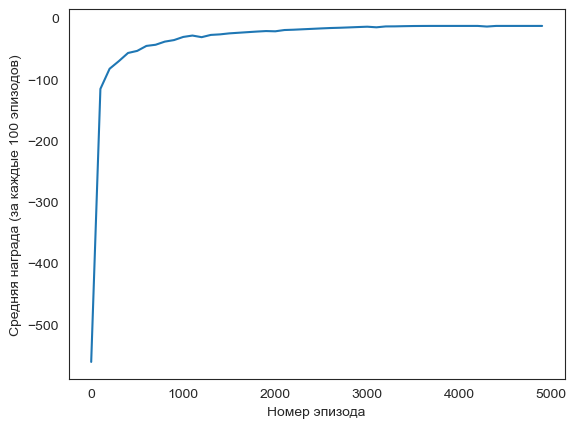

Лучшая средняя награда за 100 эпизодов: -13.0


**<span style="color: green;">PASSED</span>**


Оценённая оптимальная стратегия (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 2  3  3  1  1  1  1  3  2  1  1  0]
 [ 0  1  1  1  2  1  1  1  2  1  0  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


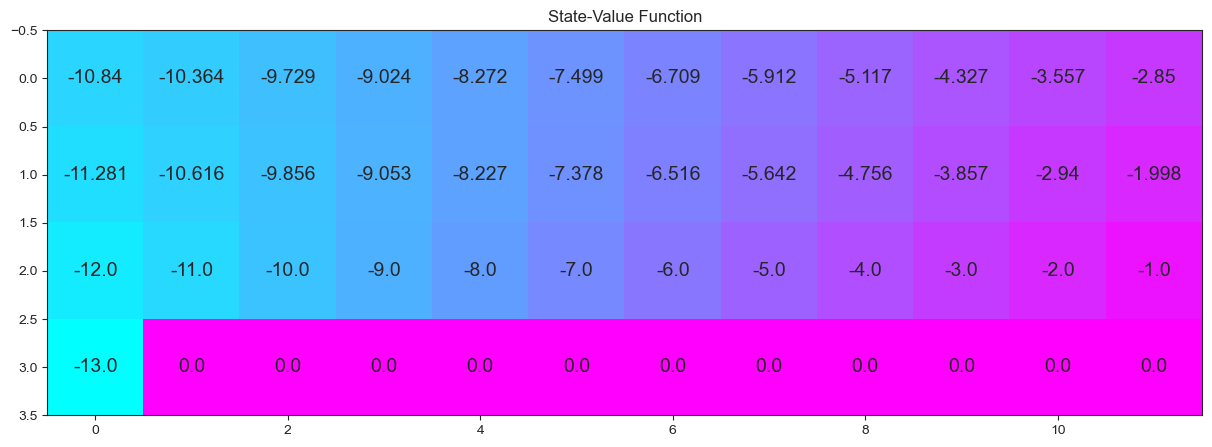

In [16]:
# получаем оценённую оптимальную стратегию и соответствующую action-value функцию
Q_sarsa = sarsa(env, 5000, .01)

# выводим оценённую оптимальную стратегию
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_sarsa)
print("\nОценённая оптимальная стратегия (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# отображаем оценённую оптимальную функцию ценности состояний
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)


Эпизод 5000/5000

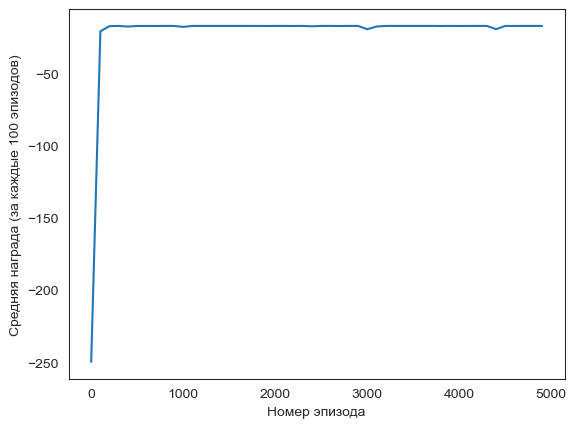

Лучшая средняя награда за 100 эпизодов: -17.0


**<span style="color: red;">PLEASE TRY AGAIN</span>**


Оценённая оптимальная стратегия (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  1  1  1  1  1  1  1  2  2  2]
 [ 1  0  0  1  1  0  1  0  1  1  2  2]
 [ 0  3  0  0  0  1  1  0  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


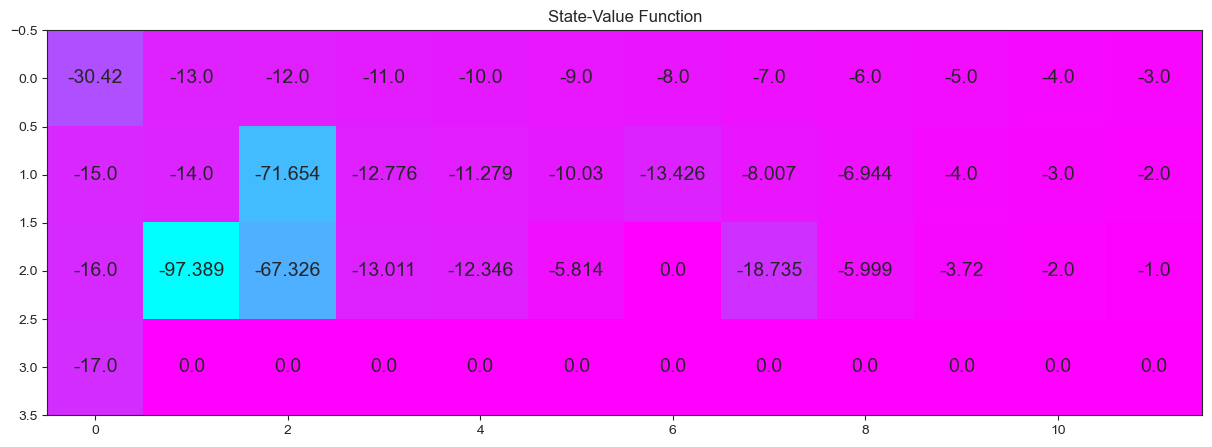

In [17]:
# получаем оценённую оптимальную стратегию и соответствующую action-value функцию
Q_sarsa = sarsa(env, 5000, 0.8)

# выводим оценённую оптимальную стратегию
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_sarsa)
print("\nОценённая оптимальная стратегия (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# отображаем оценённую оптимальную функцию ценности состояний
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)


=========================================================================================

### Часть 2: Управление с помощью TD: Q-learning

В этом разделе вам предстоит реализовать алгоритм управления на основе Temporal-Difference обучения — **Q-learning**.

---

Ваш алгоритм должен принимать следующие аргументы:

- `env`: объект среды OpenAI Gym.
- `num_episodes`: количество эпизодов, генерируемых в процессе взаимодействия агента со средой.
- `alpha`: параметр шага обучения (скорость обновления оценок).
- `gamma`: коэффициент дисконтирования. Значение должно находиться в пределах от `0` до `1` включительно (по умолчанию: `1`).

---

В качестве результата функция должна возвращать:

- `Q`: словарь (dictionary), где каждому состоянию `s` соответствует одномерный массив оценок действий:  
  `Q[s][a]` — это оценка действия `a` в состоянии `s`.

---

_Вы можете определить дополнительные функции, если это поможет структурировать ваш код._


In [18]:
def update_Q_sarsamax(alpha, gamma, Q, state, action, reward, next_state=None):
    """Возвращает обновлённое значение Q для последнего опыта (используя max(Q(s', a')) как целевое значение)."""
    current = Q[state][action]  # текущая оценка Q(s, a) из таблицы
    Qsa_next = np.max(Q[next_state]) if next_state is not None else 0  # оценка max Q(s', a')
    target = reward + (gamma * Qsa_next)               # TD-цель
    new_value = current + (alpha * (target - current)) # обновлённое значение Q(s, a)
    return new_value


In [19]:
def q_learning(env, num_episodes, alpha, gamma=1.0, plot_every=100):
    """Q-Learning — TD управление

    Параметры
    =========
        num_episodes (int): количество эпизодов
        alpha (float): скорость обучения (learning rate)
        gamma (float): коэффициент дисконтирования
        plot_every (int): интервал усреднения для вывода средней награды
    """
    nA = env.action_space.n                # количество действий
    Q = defaultdict(lambda: np.zeros(nA))  # инициализируем словарь Q-функции
    
    # для отслеживания производительности
    tmp_scores = deque(maxlen=plot_every)     # временное хранилище очков
    avg_scores = deque(maxlen=num_episodes)   # средние награды

    for i_episode in range(1, num_episodes+1):
        # отображение прогресса
        if i_episode % 100 == 0:
            print("\rЭпизод {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        score = 0
        state, _ = env.reset()                 # начинаем эпизод (с gymnasium нужно распаковать)
        eps = 1.0 / i_episode                  # значение эпсилон уменьшается с каждым эпизодом
        
        while True:
            action = epsilon_greedy(Q, state, nA, eps)  # выбираем действие по epsilon-greedy
            
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            score += reward

            Q[state][action] = update_Q_sarsamax(alpha, gamma, Q,
                                                 state, action, reward, next_state)
            state = next_state

            if done:
                tmp_scores.append(score)
                break
        
        if i_episode % plot_every == 0:
            avg_scores.append(np.mean(tmp_scores))
    
    # визуализация результатов
    plt.plot(np.linspace(0, num_episodes, len(avg_scores), endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Номер эпизода')
    plt.ylabel('Средняя награда (за каждые %d эпизодов)' % plot_every)
    plt.show()

    # вывод максимальной средней награды
    print(('Лучшая средняя награда за %d эпизодов:' % plot_every), np.max(avg_scores))
    
    return Q


Используйте следующую ячейку кода для визуализации **оценённой** (estimated) оптимальной стратегии и соответствующей функции ценности состояний.

Если выполнение ячейки возвращает **PASSED**, значит функция реализована корректно!

Вы можете свободно изменять параметры `num_episodes` и `alpha`, передаваемые в функцию.  
Однако, чтобы убедиться в точности прохождения unit-теста, **не изменяйте значение `gamma`** — оставьте его по умолчанию.


Эпизод 5000/5000

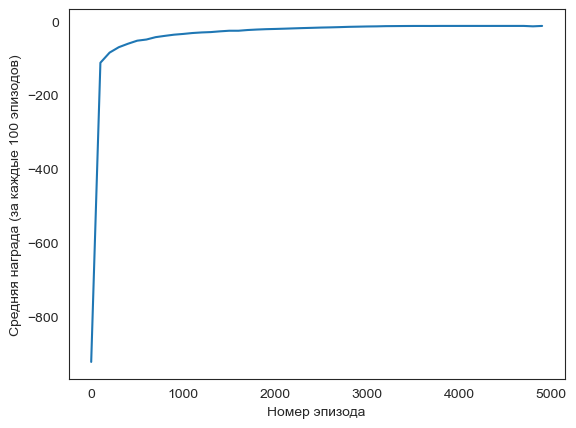

Лучшая средняя награда за 100 эпизодов: -13.0


**<span style="color: green;">PASSED</span>**


Оценённая оптимальная стратегия (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  3  0  3  1  3  1  0  1  1  2  0]
 [ 2  0  1  0  1  2  1  1  1  2  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


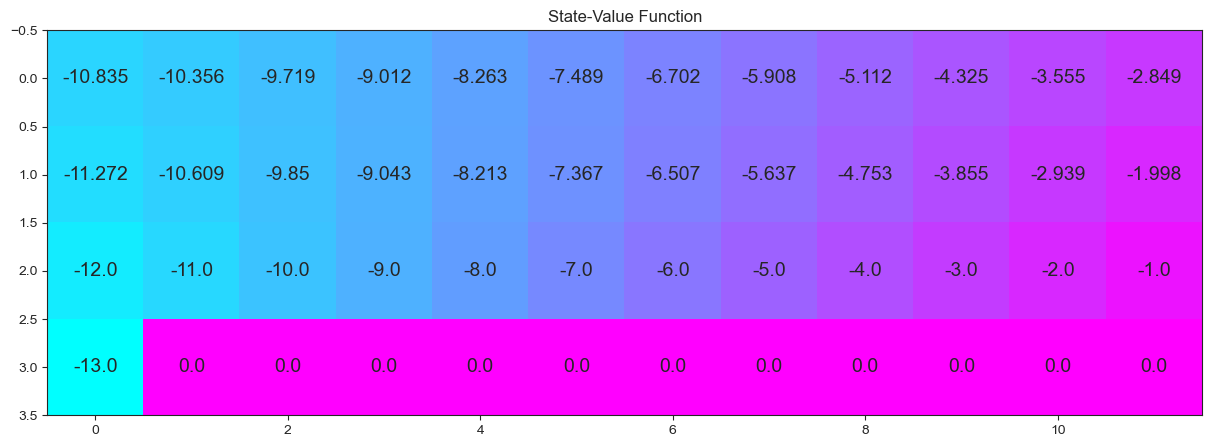

In [20]:
# получаем оценённую оптимальную стратегию и соответствующую action-value функцию
Q_sarsamax = q_learning(env, 5000, .01)

# выводим оценённую оптимальную стратегию
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
check_test.run_check('td_control_check', policy_sarsamax)
print("\nОценённая оптимальная стратегия (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# отображаем оценённую оптимальную функцию ценности состояний
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])


Эпизод 5000/5000

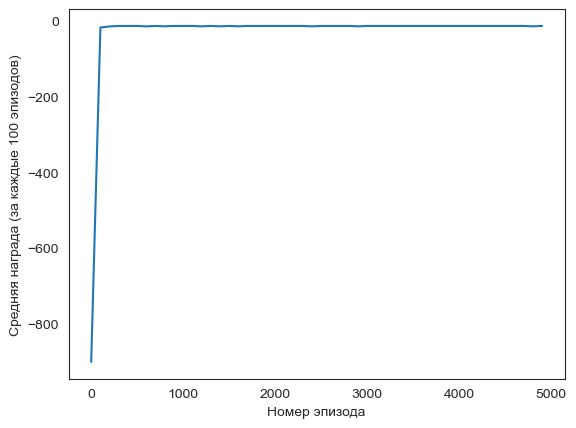

Лучшая средняя награда за 100 эпизодов: -13.0


**<span style="color: green;">PASSED</span>**


Оценённая оптимальная стратегия (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 0  2  1  1  1  1  1  1  0  0  1  1]
 [ 3  3  2  1  1  1  1  1  1  2  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


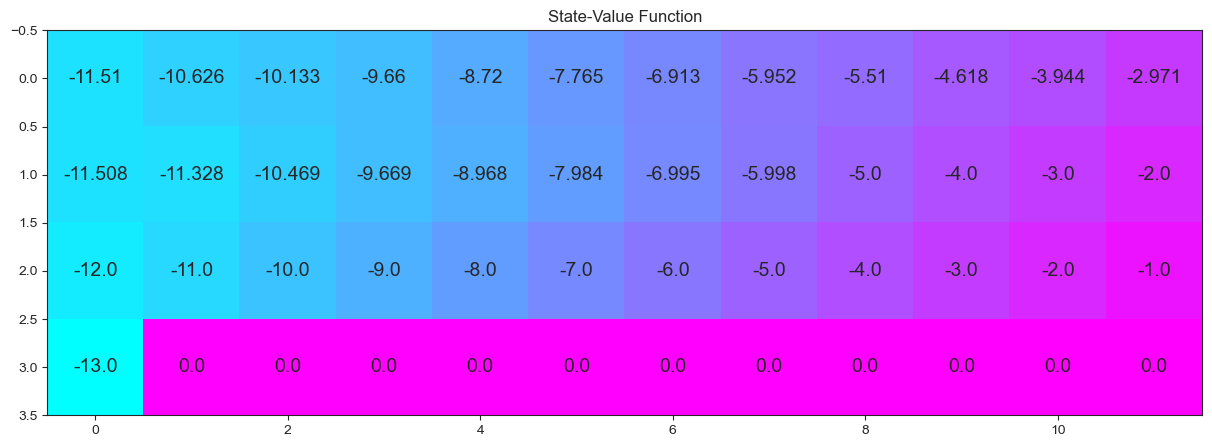

In [21]:
# получаем оценённую оптимальную стратегию и соответствующую action-value функцию
Q_sarsamax = q_learning(env, 5000, 0.9)

# выводим оценённую оптимальную стратегию
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
check_test.run_check('td_control_check', policy_sarsamax)
print("\nОценённая оптимальная стратегия (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# визуализация оценённой оптимальной функции ценности состояний
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])
